<a href="https://colab.research.google.com/github/laurenf3395/Real-vs-Fake-Images-with-ViT/blob/main/Real_or_AI_Generated_Photo_using_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-classification-real-or-ai-generated-photo:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F74720%2F8247789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T204338Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D90919afc5d96280d2fe76fd4efff436b059ee374283d24a6afcb5d0b57701ad77e49cbdbbf7f84241b19875d9560dc0ff68eae217a407062c1f0977e942cb3e98e3103acac9f051817db84d093a96cdc18bf611471564b8406a515b19a117cfe89b0f03d934464881dc501e70b3c456fa0116d7a84a269362ee15168843cf6a0f77c4981f5fa68d7ec87b52f3fb34014331ab6857a58cd00de6c0b471901800bd2b64dae29dea85ba1187eac82635031d7164c25471ba9eb07bfc63397766d5450558e09ef06d0c9d3ef28e8bc87b8b06b3f3ce8d6d4841471efcdaa1d8f8e893e7c1fb3b683d0e636f17350a008b77053543ff76b0ca8a3a3795917bdba2efd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 932850090 bytes downloaded
Downloaded and uncompressed: image-classification-real-or-ai-generated-photo
Data source import complete.


In [2]:
 ! pip install -q kaggle
 !pip install -U -q evaluate transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 928.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [3]:
from google.colab import files
files.upload()
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

Saving kaggle.json to kaggle.json
- path is now set to: {/content}


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import os
import pandas as pd
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread

# Import from hugging faces and transformers
from datasets import Dataset, Image
from transformers import ViTImageProcessor, ViTForImageClassification

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize, Resize, ToTensor

In [5]:
#First load the data

train_images_path = '/kaggle/input/image-classification-real-or-ai-generated-photo/train/train'
test_images_path = '/kaggle/input/image-classification-real-or-ai-generated-photo/test/test'

train_csv_path = '/kaggle/input/image-classification-real-or-ai-generated-photo/train.csv'
test_csv_path = '/kaggle/input/image-classification-real-or-ai-generated-photo/test.csv'

train_images = sorted(os.listdir(train_images_path), key=lambda x: int(os.path.splitext(x)[0])) #/kaggle/input/image-classification-real-or-ai-generated-photo/test
test_images = sorted(os.listdir(test_images_path), key=lambda x: int(os.path.splitext(x)[0]))

train_labels = pd.read_csv(train_csv_path)
test_labels = pd.read_csv(test_csv_path)

#Make sure that labels correctly match with each image when you work with the dataset

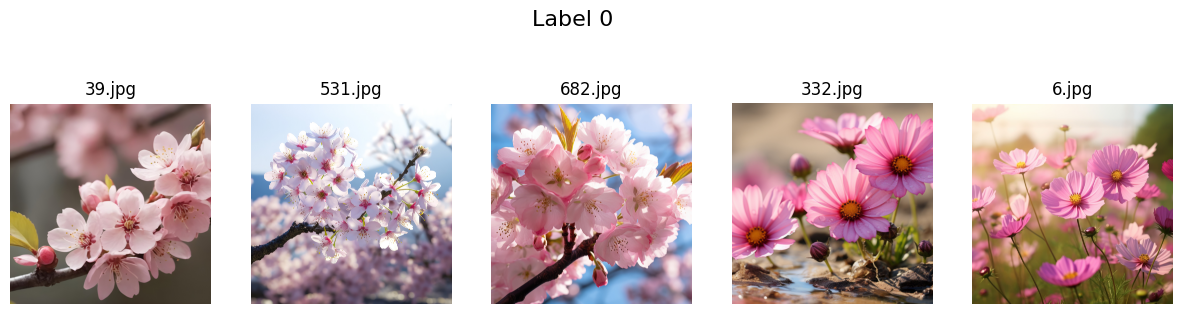

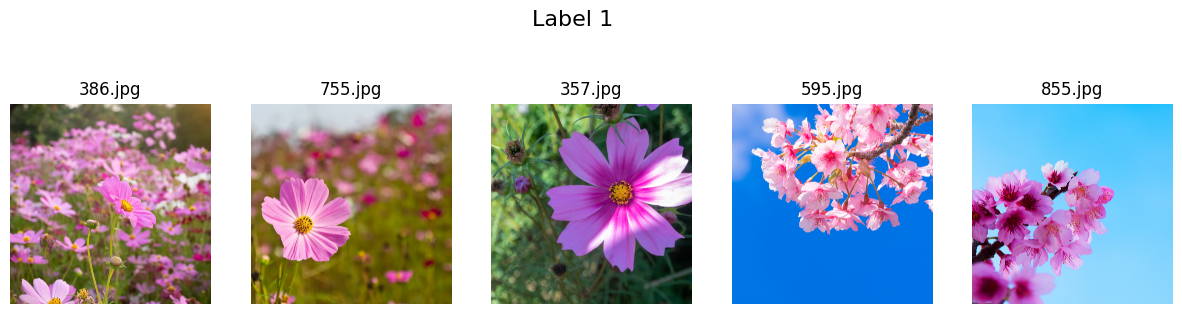

In [9]:
# Display some train images and their labels
# Remember 0 is ai-generated and 1 is authentic
def display_random_images(train_labels, num_images=5):
    for label in [0, 1]:
        filtered_train = train_labels[train_labels['Label'] == label]

        # Sample '5 random rows from the filtered dataframe
        sample_images = filtered_train.sample(n=num_images)

        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        fig.suptitle(f'Label {label}', fontsize=16)

        # Display each sampled image
        for ax, (_, row) in zip(axes, sample_images.iterrows()):
            image_path = os.path.join(train_images_path, row['Image'])
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(row['Image'])

        plt.show()

# Display 5 authentic and 5 ai-generated images. 0 = ai-generated, 1 = authentic
display_random_images(train_labels, num_images=5)

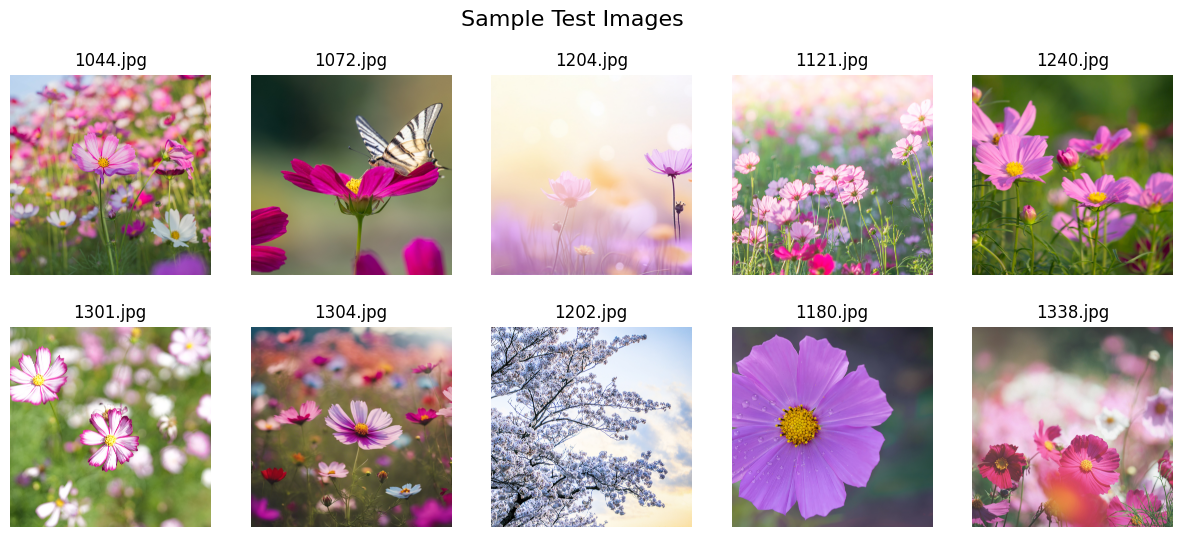

In [ ]:
sample_images_test = random.sample(test_images, 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Test Images', fontsize=16)

# Display each sampled test image
for ax, filename in zip(axes.flatten(), sample_images_test):
    image_path = os.path.join(test_images_path, filename)
    try:
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(filename)
    except Exception as e:
        print(f"Error opening {image_path}: {e}")
        ax.set_title('Error loading image')
        ax.axis('off')

plt.show()


In [6]:
# Add image path to csv file
print(train_images_path)
print(train_labels['Image'][0])

train_labels['Image'] = train_labels['Image'].apply(lambda x: "{}{}".format(train_images_path + "/", x))
print(train_labels["Image"][0])

test_labels['Image'] = test_labels['Image'].apply(lambda x: "{}{}".format(test_images_path + "/", x))


/kaggle/input/image-classification-real-or-ai-generated-photo/train/train
1.jpg
/kaggle/input/image-classification-real-or-ai-generated-photo/train/train/1.jpg


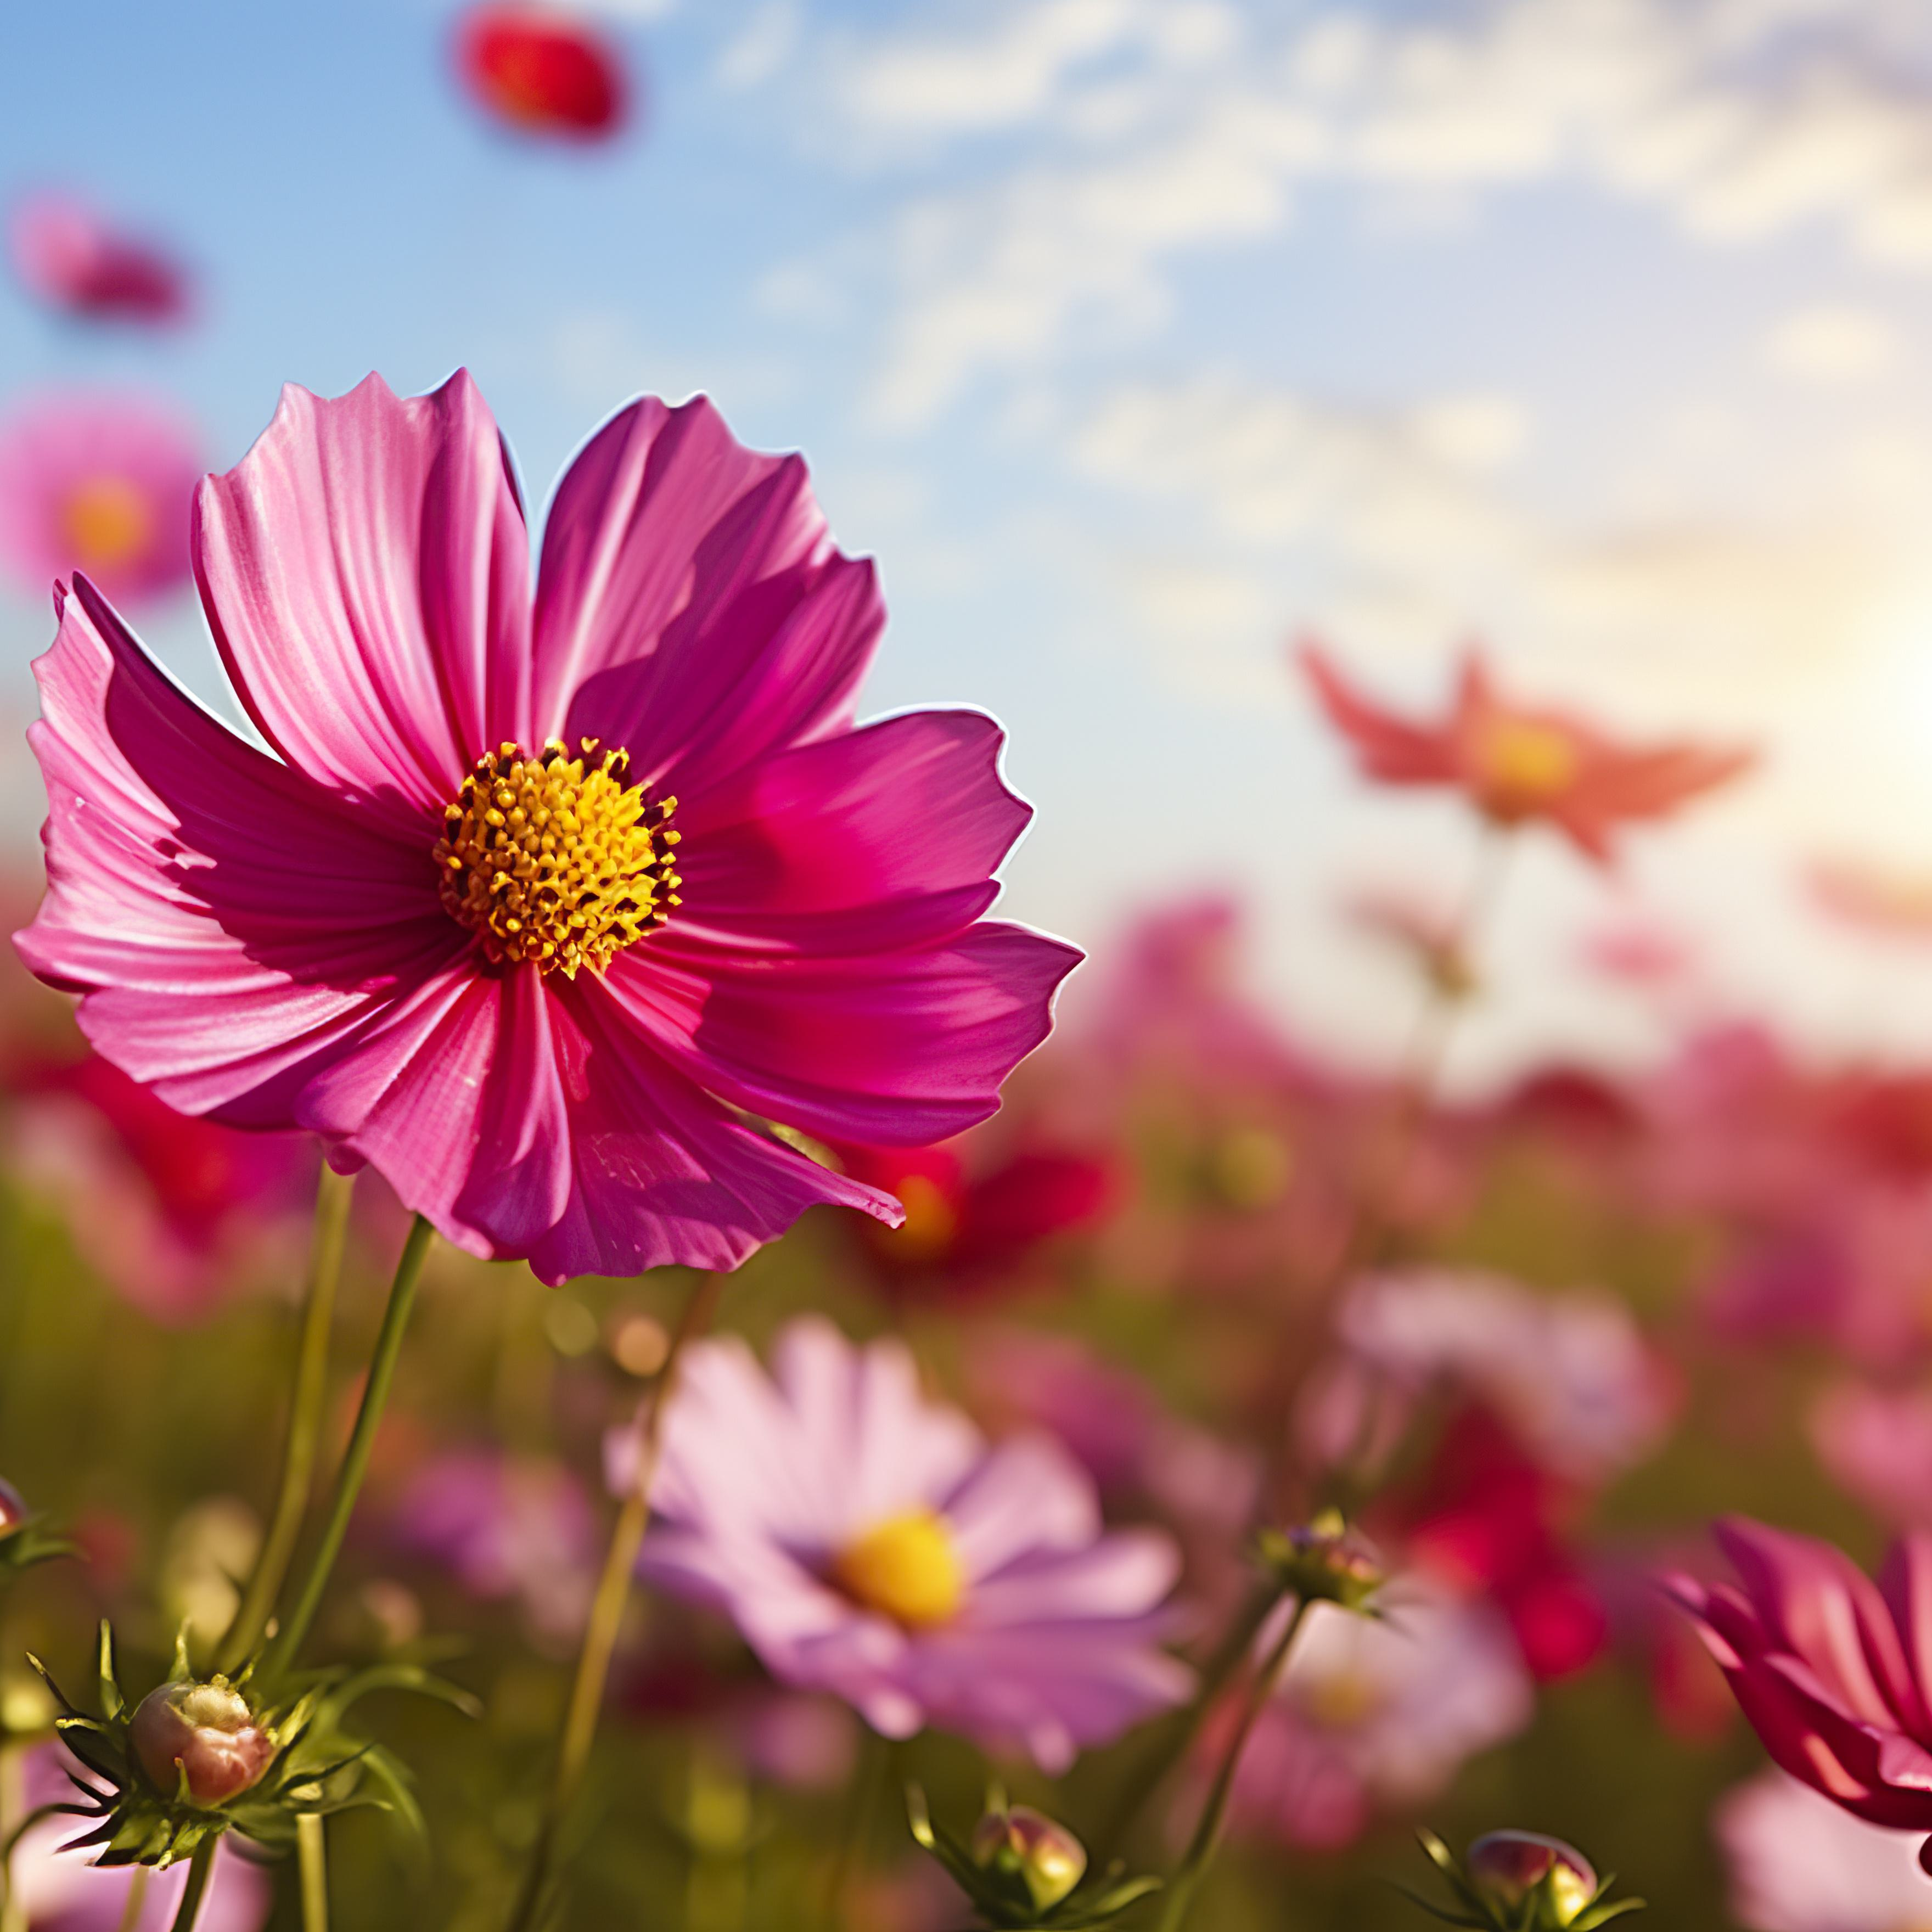

In [7]:
# Create a dataset from the Pandas DataFrame.
dataset = Dataset.from_pandas(train_labels).cast_column("Image", Image())

dataset[0]["Image"]


In [8]:
labels_list = list(train_labels['Label'].unique())

# Splitting the dataset into training and testing sets using an 60-40 split ratio.

# First cast the given column as ClassLabel and update the table.
dataset = dataset.class_encode_column("Label")

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="Label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Stringifying the column:   0%|          | 0/945 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/945 [00:00<?, ? examples/s]

In [10]:
# Now the Vision transformer model: add pretrained model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

#Normalize images
img_mean, img_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# print size of train image

# Define a normalization transformation for the input images
normalize = Normalize(mean=img_mean, std=img_std)


Size:  224


In [ ]:
def predict_label(test_data):
  return [random.choice([0, 1]) for _ in range(len(test_data))]

predictions = predict_label(test_images)
sample_submission = pd.DataFrame({'Image': [img for img in test_images], 'Label': predictions})

sample_submission.head()

Image  Label
0  946.jpg      0
1  947.jpg      0
2  948.jpg      0
3  949.jpg      0
4  950.jpg      1

In [ ]:
sample_submission.to_csv('/kaggle/working/sample_submission.csv', index=False)

In [ ]:
 ! pip install -q kaggle

In [ ]:
files.upload();

NameError: name 'files' is not defined